# Raw implementation without saving Maximum Reward model


[link text](https://)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
class GridWorldEnv:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        # Initialize agent position randomly
        self.agent_pos = [random.randint(0, self.size-1), random.randint(0, self.size-1)]
        # Set goal position randomly but ensure it's different from agent position
        self.goal_pos = self.agent_pos.copy()
        while self.goal_pos == self.agent_pos:
            self.goal_pos = [random.randint(0, self.size-1), random.randint(0, self.size-1)]
        return self._get_state()

    def step(self, action):
        # Actions: 0: up, 1: right, 2: down, 3: left
        if action == 0 and self.agent_pos[0] > 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < self.size - 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < self.size - 1:  # Down
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:  # Left
            self.agent_pos[1] -= 1

        # Check if goal is reached
        done = (self.agent_pos == self.goal_pos)

        # Calculate reward: -0.1 per step, +1 for reaching goal
        reward = 1.0 if done else -0.1

        return self._get_state(), reward, done

    def _get_state(self):
        # State is represented as [agent_x, agent_y, goal_x, goal_y]
        return np.array([self.agent_pos[0], self.agent_pos[1],
                         self.goal_pos[0], self.goal_pos[1]])

    def render(self):
        grid = np.zeros((self.size, self.size), dtype=str)
        grid.fill('.')
        grid[self.agent_pos[0], self.agent_pos[1]] = 'A'
        grid[self.goal_pos[0], self.goal_pos[1]] = 'G'

        # If agent and goal are in the same position
        if self.agent_pos == self.goal_pos:
            grid[self.agent_pos[0], self.agent_pos[1]] = 'X'

        for row in grid:
            print(' '.join(row))
        print()


In [4]:

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)


In [5]:
# Define the value network
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.network(x)


In [6]:
def generate_trajectories(env, policy_net, num_episodes=10, max_steps=100):
    trajectories = []

    for _ in range(num_episodes):
        states, actions, rewards, log_probs = [], [], [], []
        state = env.reset()
        done = False
        step_count = 0

        while not done and step_count < max_steps:
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs = policy_net(state_tensor)

            # Sample action from the distribution
            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)

            next_state, reward, done = env.step(action.item())

            states.append(state)
            actions.append(action.item())
            rewards.append(reward)
            log_probs.append(log_prob.item())

            state = next_state
            step_count += 1

        # Calculate returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + 0.99 * G  # 0.99 is the discount factor
            returns.insert(0, G)

        trajectories.append({
            'states': np.array(states),
            'actions': np.array(actions),
            'rewards': np.array(rewards),
            'returns': np.array(returns),
            'log_probs': np.array(log_probs)
        })

    return trajectories

In [7]:
# Function to generate reference and candidate trajectories for preference learning
def generate_preference_pairs(env, policy_net, value_net, num_pairs=5, max_steps=100):
    reference_trajectories = generate_trajectories(env, policy_net, num_episodes=num_pairs, max_steps=max_steps)
    candidate_trajectories = generate_trajectories(env, policy_net, num_episodes=num_pairs, max_steps=max_steps)

    pairs = []
    for ref_traj, cand_traj in zip(reference_trajectories, candidate_trajectories):
        # Use total return as a proxy for preference
        ref_return = np.sum(ref_traj['rewards'])
        cand_return = np.sum(cand_traj['rewards'])

        # Determine which trajectory is preferred based on total return
        if ref_return > cand_return:
            preferred = ref_traj
            non_preferred = cand_traj
        else:
            preferred = cand_traj
            non_preferred = ref_traj

        pairs.append((preferred, non_preferred))

    return pairs


In [23]:
# training function with GRPO =>
def train_grpo(env, policy_net, value_net, optimizer_policy, optimizer_value,
               num_iterations=100, batch_size=4, max_steps=100):

    returns_history = []
    loss_history = []

    for iteration in tqdm(range(num_iterations)):
        # Generate preference pairs
        preference_pairs = generate_preference_pairs(env, policy_net, value_net,
                                                    num_pairs=batch_size, max_steps=max_steps)

        # Train on preference pairs
        policy_loss = 0
        value_loss = 0

        for preferred, non_preferred in preference_pairs:
            # Value loss
            preferred_states = torch.FloatTensor(preferred['states']).to(device)
            preferred_returns = torch.FloatTensor(preferred['returns']).unsqueeze(1).to(device)
            predicted_values = value_net(preferred_states)
            batch_value_loss = nn.MSELoss()(predicted_values, preferred_returns)
            value_loss += batch_value_loss

            # Policy loss - GRPO approach
            # Calculate advantage using the value network
            advantages = preferred_returns - predicted_values.detach()

            # Get log probabilities of actions taken
            preferred_actions = torch.LongTensor(preferred['actions']).to(device)
            action_probs = policy_net(preferred_states)
            dist = torch.distributions.Categorical(action_probs)
            log_probs = dist.log_prob(preferred_actions)

            # Calculate importance weights from old log probs
            old_log_probs = torch.FloatTensor(preferred['log_probs']).to(device)
            ratios = torch.exp(log_probs - old_log_probs)

            # Clipped PPO loss
            eps = 0.2  # PPO clipping parameter
            clipped_ratios = torch.clamp(ratios, 1-eps, 1+eps)
            batch_policy_loss = -torch.min(ratios * advantages, clipped_ratios * advantages).mean()
            policy_loss += batch_policy_loss

        # Average losses
        policy_loss /= len(preference_pairs)
        value_loss /= len(preference_pairs)

        # Update policy network
        optimizer_policy.zero_grad()
        policy_loss.backward()
        optimizer_policy.step()

        # Update value network
        optimizer_value.zero_grad()
        value_loss.backward()
        optimizer_value.step()

        # Evaluate performance
        if iteration % 100 == 0:
            eval_returns = []
            for _ in range(5):  # Evaluate on 5 episodes
                state = env.reset()
                total_reward = 0
                done = False
                step_count = 0

                while not done and step_count < max_steps:
                    state_tensor = torch.FloatTensor(state).to(device)
                    action_probs = policy_net(state_tensor)
                    action = torch.argmax(action_probs).item()

                    next_state, reward, done = env.step(action)
                    total_reward += reward
                    state = next_state
                    step_count += 1

                eval_returns.append(total_reward)

            avg_return = np.mean(eval_returns)
            returns_history.append(avg_return)
            loss_history.append((policy_loss.item(), value_loss.item()))

            print(f"Iteration {iteration}, Avg Return: {avg_return:.2f}, " +
                  f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

    return returns_history, loss_history


In [32]:
# Create environment and networks
env = GridWorldEnv(size=5)

# State size: agent_x, agent_y, goal_x, goal_y
state_size = 4
hidden_size = 64
action_size = 4  # up, right, down, left

policy_net = PolicyNetwork(state_size, hidden_size, action_size).to(device)
value_net = ValueNetwork(state_size, hidden_size).to(device)

optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.001)
optimizer_value = optim.Adam(value_net.parameters(), lr=0.001)

# Train the agent
print("Starting GRPO training...")
returns_history, loss_history = train_grpo(
    env, policy_net, value_net, optimizer_policy, optimizer_value,
    num_iterations=1000, batch_size=4, max_steps=20
)

Starting GRPO training...


  0%|          | 2/1000 [00:00<02:57,  5.61it/s]

Iteration 0, Avg Return: -2.00, Policy Loss: 0.3999, Value Loss: 0.9773


 10%|█         | 102/1000 [00:14<01:48,  8.25it/s]

Iteration 100, Avg Return: -0.40, Policy Loss: -0.2327, Value Loss: 0.1672


 20%|██        | 202/1000 [00:24<01:10, 11.29it/s]

Iteration 200, Avg Return: 0.04, Policy Loss: -0.0604, Value Loss: 0.1244


 30%|███       | 304/1000 [00:32<00:40, 17.33it/s]

Iteration 300, Avg Return: 0.82, Policy Loss: 0.0087, Value Loss: 0.0203


 40%|████      | 403/1000 [00:38<00:32, 18.25it/s]

Iteration 400, Avg Return: 0.82, Policy Loss: -0.0466, Value Loss: 0.0046


 50%|█████     | 503/1000 [00:43<00:24, 20.31it/s]

Iteration 500, Avg Return: 0.82, Policy Loss: 0.0137, Value Loss: 0.0030


 60%|██████    | 605/1000 [00:47<00:17, 22.18it/s]

Iteration 600, Avg Return: 0.90, Policy Loss: 0.0161, Value Loss: 0.0050


 70%|███████   | 703/1000 [00:52<00:17, 17.38it/s]

Iteration 700, Avg Return: 0.82, Policy Loss: -0.0117, Value Loss: 0.0014


 81%|████████  | 806/1000 [00:57<00:07, 24.52it/s]

Iteration 800, Avg Return: 0.60, Policy Loss: -0.0074, Value Loss: 0.0016


 90%|█████████ | 905/1000 [01:01<00:04, 23.46it/s]

Iteration 900, Avg Return: 0.74, Policy Loss: 0.0083, Value Loss: 0.0011


100%|██████████| 1000/1000 [01:06<00:00, 15.14it/s]


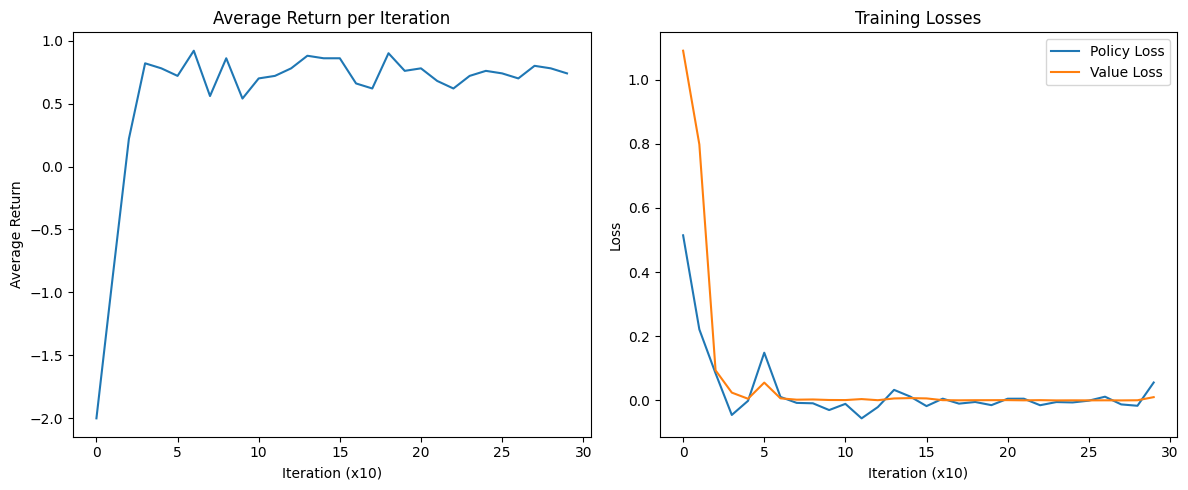

In [28]:
# Plot training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(returns_history)
plt.title('Average Return per Iteration')
plt.xlabel('Iteration (x10)')
plt.ylabel('Average Return')

plt.subplot(1, 2, 2)
policy_losses = [x[0] for x in loss_history]
value_losses = [x[1] for x in loss_history]
plt.plot(policy_losses, label='Policy Loss')
plt.plot(value_losses, label='Value Loss')
plt.title('Training Losses')
plt.xlabel('Iteration (x10)')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
# train for n epochs
# epochs = 10
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     returns_history, loss_history = train_grpo(
#         env, policy_net, value_net, optimizer_policy, optimizer_value,
#         num_iterations=10, batch_size=4, max_steps=20
#     )
#         # Plot training results
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(returns_history)
#     plt.title('Average Return per Iteration')
#     plt.xlabel('Iteration (x10)')
#     plt.ylabel('Average Return')

#     plt.subplot(1, 2, 2)
#     policy_losses = [x[0] for x in loss_history]
#     value_losses = [x[1] for x in loss_history]
#     plt.plot(policy_losses, label='Policy Loss')
#     plt.plot(value_losses, label='Value Loss')
#     plt.title('Training Losses')
#     plt.xlabel('Iteration (x10)')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

In [35]:
 # Demonstrate trained agent
print("\nDemonstrating trained agent:")
state = env.reset()
env.render()

done = False
step_count = 0
total_reward = 0

while not done and step_count < 20:
    state_tensor = torch.FloatTensor(state).to(device)
    action_probs = policy_net(state_tensor)
    action = torch.argmax(action_probs).item()

    action_names = ["UP", "RIGHT", "DOWN", "LEFT"]
    print(f"Step {step_count+1}: Agent chooses {action_names[action]}")

    next_state, reward, done = env.step(action)
    total_reward += reward
    state = next_state
    env.render()
    step_count += 1

print(f"Episode finished with total reward: {total_reward:.2f}")
if done:
    print("Goal reached!")
else:
    print("Maximum steps reached before finding goal.")


Demonstrating trained agent:
. . . . .
. . . A .
. . . . .
. . . G .
. . . . .

Step 1: Agent chooses DOWN
. . . . .
. . . . .
. . . A .
. . . G .
. . . . .

Step 2: Agent chooses DOWN
. . . . .
. . . . .
. . . . .
. . . X .
. . . . .

Episode finished with total reward: 0.90
Goal reached!
